In [2]:
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing, ensemble

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Считывание данных train.csv

In [3]:
raw_data = pd.read_csv('train.csv', header=0, sep=',')
raw_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

### Визуализация
Построим несколько графиков, чтобы иметь представление о зависимости вероятности выживания от определенных фаторов (Sex, Pclass и Embarked соответственно)

/usr/lib/python3/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


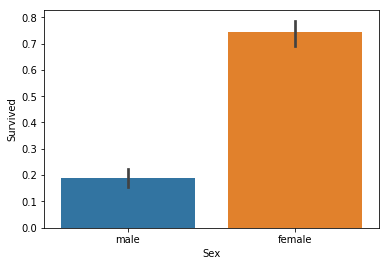

In [4]:
sns.barplot(x='Sex', y='Survived', data=raw_data)

/usr/lib/python3/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


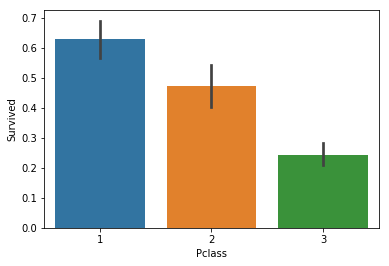

In [5]:
sns.barplot(x='Pclass', y='Survived', data=raw_data)

/usr/lib/python3/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


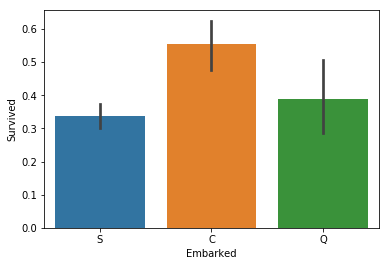

In [6]:
sns.barplot(x='Embarked', y='Survived', data=raw_data)

### Проанализировав входные данные, заметим, что  среди всех представленных признаков - 1 бинарный, 6 вещественных и 5 категориальных признаков. Кроме того, среди признаков есть те, что являются уникальными, и не смогут принести пользу при обучении модели. Это признаки PassengerId и Name. Уберем их из набора данных за ненадобностью. Кроме того, отделим метки (признак Survived)

In [7]:
data = raw_data.drop(['Survived', 'PassengerId', 'Name'], axis=1)
labels = raw_data['Survived'].values
data.head()

Pclass     Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
0       3    male  22.0      1      0         A/5 21171   7.2500   NaN   
1       1  female  38.0      1      0          PC 17599  71.2833   C85   
2       3  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
3       1  female  35.0      1      0            113803  53.1000  C123   
4       3    male  35.0      0      0            373450   8.0500   NaN   

  Embarked  
0        S  
1        C  
2        S  
3        S  
4        S

### Некоторые ячейки таблицы не заполнены. Мы можем заполнить их нулями, однако, в случае с возрастом, это может нанести вред, так как количество пустых ячеек в данной колонке велико. Попробуем заменить пустые ячейки на среднее и медианное значение возраста, затем решим, что эффективнее.

In [8]:
mean_age = data['Age'].mean()
median_age = data['Age'].median()
# data['Age'].fillna(mean_age, inplace=True)
data['Age'].fillna(median_age, inplace=True)

### Теперь в нашем наборе данных 6 вещественных и 3 категориальных признака. С помощью функции preprocessing.LabelEncoder() категориальным признакам поставим в соответствие вещественные числа, чтобы потом работать с этими признаками, преобразуя их в n бинарных (где n - количество значений, которые может принимать категориальный признак)

In [9]:
data.fillna(0, inplace=True)
le_sex = preprocessing.LabelEncoder()
le_sex.fit(data.Sex)
data['Sex'] = le_sex.transform(data.Sex)
le_cabin = preprocessing.LabelEncoder()
le_cabin.fit(data.Cabin.astype(str))
data['Cabin'] = le_cabin.transform(data.Cabin.astype(str))
le_embarked = preprocessing.LabelEncoder()
le_embarked.fit(data.Embarked.astype(str))
data['Embarked'] = le_embarked.transform(data.Embarked.astype(str))
le_ticket = preprocessing.LabelEncoder()
le_ticket.fit(data.Ticket.astype(str))
data['Ticket'] = le_ticket.transform(data.Ticket.astype(str))

### Разобьём данные на обучение и тест, разделим данные по типам (категориальные и бинарные), так они они обрабатываются по-разному.

In [10]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(data, labels, test_size=0.2, random_state=1)

In [11]:
categorical_data_columns = ['Sex', 'Cabin', 'Embarked', 'Ticket'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)
numeric_data_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

### Построим линейную модель, а именно логистическую регрессию. Построим pipeline, для вещественных данных будем проведем масштабирование признаков, категориальные преобразуем в бинарные.

In [12]:
log_regressor = linear_model.LogisticRegression(random_state=1)

In [46]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [                         
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[: numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[: categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', log_regressor)
    ]
)

### Подберем параметры по сетке, используя кросс-валидацию.

In [14]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__selecting', 'feature_processing__numeric_variables_processing__scaling', 'feature_processing__numeric_variables_processing__selecting__accept_sparse', 'feature_processing__numeric_variables_processing__selecting__func', 'feature_processing__numeric_variables_processing__selecting__inv_kw_args', 'feature_processing__numeric_variables_processing__selecting__inverse_func', 'feature_processing__numeric_variables_processing__selecting__kw_args', 'feature_processing__numeric_variables_processing__selecting__pass_y', 'feature_processing__num

In [15]:
parameters_grid = {
    'model_fitting__penalty' : ['l1', 'l2'],
    'model_fitting__max_iter': np.arange(1, 20),
    'model_fitting__C': [0.5, 0.51, 0.6, 0.61]
}

In [16]:
cv = cross_validation.StratifiedShuffleSplit(train_labels, n_iter = 10, test_size = 0.2, random_state = 1)

In [17]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring = 'accuracy', cv = cv)

In [18]:
grid_cv.fit(train_data, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 1 ..., 0 0], n_iter=10, test_size=0.2, random_state=1),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_variables_processing', Pipeline(memory=None,
     steps=[('selecting', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f9e1d1e32f0>, inv_kw_args=None,
          inverse_func=None,...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__penalty': ['l1', 'l2'], 'model_fitting__max_iter': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]), 'model_fitting__C': [0.5, 0.51, 0.6, 0.61]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [19]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8614648356221392
{'model_fitting__C': 0.61, 'model_fitting__max_iter': 4, 'model_fitting__penalty': 'l2'}


### Проверим качество на тестовом сете

In [20]:
test_data = pd.read_csv('test.csv', header=0, sep=',')
droped_test_data = test_data.drop(['PassengerId', 'Name'], axis=1)
test_mean_age = droped_test_data['Age'].mean()
test_median_age = droped_test_data['Age'].median()
# droped_test_data['Age'].fillna(test_mean_age, inplace=True)
droped_test_data['Age'].fillna(test_median_age, inplace=True)
droped_test_data.fillna(0, inplace=True)
le_sex = preprocessing.LabelEncoder()
le_sex.fit(droped_test_data.Sex)
droped_test_data['Sex'] = le_sex.transform(droped_test_data.Sex)
le_cabin = preprocessing.LabelEncoder()
le_cabin.fit(droped_test_data.Cabin.astype(str))
droped_test_data['Cabin'] = le_cabin.transform(droped_test_data.Cabin.astype(str))
le_embarked = preprocessing.LabelEncoder()
le_embarked.fit(droped_test_data.Embarked.astype(str))
droped_test_data['Embarked'] = le_embarked.transform(droped_test_data.Embarked.astype(str))
le_ticket = preprocessing.LabelEncoder()
le_ticket.fit(droped_test_data.Ticket.astype(str))
droped_test_data['Ticket'] = le_ticket.transform(droped_test_data.Ticket.astype(str))


In [21]:
predicted_data = grid_cv.predict(droped_test_data)

In [22]:
PassengerId_test_data = test_data['PassengerId'].values
dataframe = pd.DataFrame({'PassengerId':PassengerId_test_data, 'Survived':predicted_data}) 
pd.DataFrame.to_csv(dataframe,"prediction.csv", index=False)

   ### Построим другие модели, чтобы сравнить полученные результаты и решить, какая из моделей дает наиболее точный прогноз. Случайный лес имеет низкое смещение и разброс, что может дать лучший результат.

In [23]:
rf_classifier = ensemble.RandomForestClassifier(max_depth = 10, n_estimators = 50, random_state=1)

In [24]:
estimator_random_forest = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [             
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', rf_classifier)
    ]
)

In [25]:
estimator_random_forest.get_params().keys()

dict_keys(['memory', 'steps', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__selecting', 'feature_processing__numeric_variables_processing__scaling', 'feature_processing__numeric_variables_processing__selecting__accept_sparse', 'feature_processing__numeric_variables_processing__selecting__func', 'feature_processing__numeric_variables_processing__selecting__inv_kw_args', 'feature_processing__numeric_variables_processing__selecting__inverse_func', 'feature_processing__numeric_variables_processing__selecting__kw_args', 'feature_processing__numeric_variables_processing__selecting__pass_y', 'feature_processing__num

In [26]:
parameters_grid_random_forest = {
    'model_fitting__n_estimators' :np.arange(1, 100, 4),
    'model_fitting__max_depth': np.arange(1, 50, 4),
}

In [27]:
grid_cv_random_forest = grid_search.GridSearchCV(estimator_random_forest, parameters_grid_random_forest, scoring = 'accuracy', cv = cv)

In [28]:
grid_cv_random_forest.fit(train_data, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 1 ..., 0 0], n_iter=10, test_size=0.2, random_state=1),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_variables_processing', Pipeline(memory=None,
     steps=[('selecting', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f9e1d1e3ea0>, inv_kw_args=None,
          inverse_func=None,...estimators=50, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__n_estimators': array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
       69, 73, 77, 81, 85, 89, 93, 97]), 'model_fitting__max_depth': array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [29]:
print(grid_cv_random_forest.best_score_)
print(grid_cv_random_forest.best_params_)

0.8398601398601399
{'model_fitting__max_depth': 45, 'model_fitting__n_estimators': 65}


In [30]:
test_data = pd.read_csv('test.csv', header=0, sep=',')
droped_test_data = test_data.drop(['PassengerId', 'Name'], axis=1)
test_mean_age = droped_test_data['Age'].mean()
test_median_age = droped_test_data['Age'].median()
# droped_test_data['Age'].fillna(test_mean_age, inplace=True)
droped_test_data['Age'].fillna(test_median_age, inplace=True)
droped_test_data.fillna(0, inplace=True)
le_sex = preprocessing.LabelEncoder()
le_sex.fit(droped_test_data.Sex)
droped_test_data['Sex'] = le_sex.transform(droped_test_data.Sex)
le_cabin = preprocessing.LabelEncoder()
le_cabin.fit(droped_test_data.Cabin.astype(str))
droped_test_data['Cabin'] = le_cabin.transform(droped_test_data.Cabin.astype(str))
le_embarked = preprocessing.LabelEncoder()
le_embarked.fit(droped_test_data.Embarked.astype(str))
droped_test_data['Embarked'] = le_embarked.transform(droped_test_data.Embarked.astype(str))
le_ticket = preprocessing.LabelEncoder()
le_ticket.fit(droped_test_data.Ticket.astype(str))
droped_test_data['Ticket'] = le_ticket.transform(droped_test_data.Ticket.astype(str))


In [31]:
predicted_data = grid_cv_random_forest.predict(droped_test_data)

In [32]:
PassengerId_test_data = test_data['PassengerId'].values
dataframe = pd.DataFrame({'PassengerId':PassengerId_test_data, 'Survived':predicted_data}) 
pd.DataFrame.to_csv(dataframe,"prediction.csv", index=False)

### Построим еще одну модель - GBoost. Сравним ее эффективность с результатами, полученными с помощью других моделей.

In [33]:
gb_classifier = ensemble.GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05, random_state=1)

In [34]:
estimator_gboost = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [             
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', gb_classifier)
    ]
)

In [35]:
estimator_gboost.get_params().keys()

dict_keys(['memory', 'steps', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__selecting', 'feature_processing__numeric_variables_processing__scaling', 'feature_processing__numeric_variables_processing__selecting__accept_sparse', 'feature_processing__numeric_variables_processing__selecting__func', 'feature_processing__numeric_variables_processing__selecting__inv_kw_args', 'feature_processing__numeric_variables_processing__selecting__inverse_func', 'feature_processing__numeric_variables_processing__selecting__kw_args', 'feature_processing__numeric_variables_processing__selecting__pass_y', 'feature_processing__num

In [36]:
parameters_grid_gboost = {
    'model_fitting__min_samples_split' :np.arange(4, 10),
    'model_fitting__max_depth': np.arange(5, 8),    
}

In [37]:
grid_cv_gboost = grid_search.GridSearchCV(estimator_gboost, parameters_grid_gboost, scoring = 'accuracy', cv = cv)

In [38]:
grid_cv_gboost.fit(train_data, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 1 ..., 0 0], n_iter=10, test_size=0.2, random_state=1),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_variables_processing', Pipeline(memory=None,
     steps=[('selecting', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f9e1d1e3e18>, inv_kw_args=None,
          inverse_func=None,...         presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__min_samples_split': array([4, 5, 6, 7, 8, 9]), 'model_fitting__max_depth': array([5, 6, 7])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [39]:
print(grid_cv_gboost.best_score_)
print(grid_cv_gboost.best_params_)

0.8356643356643356
{'model_fitting__max_depth': 6, 'model_fitting__min_samples_split': 8}


In [40]:
test_data = pd.read_csv('test.csv', header=0, sep=',')
droped_test_data = test_data.drop(['PassengerId', 'Name'], axis=1)
test_mean_age = droped_test_data['Age'].mean()
test_median_age = droped_test_data['Age'].median()
# droped_test_data['Age'].fillna(test_mean_age, inplace=True)
droped_test_data['Age'].fillna(test_median_age, inplace=True)
droped_test_data.fillna(0, inplace=True)
le_sex = preprocessing.LabelEncoder()
le_sex.fit(droped_test_data.Sex)
droped_test_data['Sex'] = le_sex.transform(droped_test_data.Sex)
le_cabin = preprocessing.LabelEncoder()
le_cabin.fit(droped_test_data.Cabin.astype(str))
droped_test_data['Cabin'] = le_cabin.transform(droped_test_data.Cabin.astype(str))
le_embarked = preprocessing.LabelEncoder()
le_embarked.fit(droped_test_data.Embarked.astype(str))
droped_test_data['Embarked'] = le_embarked.transform(droped_test_data.Embarked.astype(str))
le_ticket = preprocessing.LabelEncoder()
le_ticket.fit(droped_test_data.Ticket.astype(str))
droped_test_data['Ticket'] = le_ticket.transform(droped_test_data.Ticket.astype(str))

In [41]:
predicted_data = grid_cv_gboost.predict(droped_test_data)

In [42]:
PassengerId_test_data = test_data['PassengerId'].values
dataframe = pd.DataFrame({'PassengerId':PassengerId_test_data, 'Survived':predicted_data}) 
pd.DataFrame.to_csv(dataframe,"prediction.csv", index=False)